## 16 Evaluate Fit Spectra
Each model is evaluated on how well it's able to fit the integrated spectra using the predicted fitting parameters with XRF-Maps compared to the experimental values.

In [1]:
import pandas as pd
import numpy as np
import pyxrfmaps as px 
import matplotlib.pyplot as plt
import pickle
import xgboost
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

In [2]:
spectra = pd.read_csv('./training_data/07_test_int_spectra.csv', header=None)
normalized_spectra = pd.read_csv('./training_data/08_test_int_spectra.csv', header=None)

fit_params_to_predict = pd.read_csv('./training_data/04_fit_params_to_predict.csv')
fit_params_constant = pd.read_csv('./training_data/04_fit_params_constant.csv')
elements = pd.read_csv('./training_data/07_test_elements.csv')

with open('./training_data/07_test_fit_spectra.csv') as f:
    experimental_fit_spectra = f.readlines()
with open('./training_data/07_test_resize_spectra.csv') as f:
    experimental_resize_spectra = f.readlines()

In [3]:
print(len(spectra))
print(len(experimental_fit_spectra))
print(len(experimental_resize_spectra))
print(len(elements))

6650
6650
6650
6650


In [4]:
for i in range(len(experimental_fit_spectra)):
    experimental_fit_spectra[i] = np.array(experimental_fit_spectra[i].strip().split(','), dtype=float)
    experimental_resize_spectra[i] = np.array(experimental_resize_spectra[i].strip().split(','), dtype=float)

In [5]:
#Score the experimental fits
all_experimental_r2 = []
all_experimental_spear = []
for i in range(len(experimental_fit_spectra)):
    expected = experimental_resize_spectra[i]
    fit = experimental_fit_spectra[i]
    score = r2_score(expected, fit)
    all_experimental_r2.append(score if score >= 0 else 0)
    score = spearmanr(expected, fit).statistic
    all_experimental_spear.append(score if score >= 0 else 0)

In [6]:
#Load the models
xgb_model = pickle.load(open('13_xgboost.sav', 'rb'))
mlp_model = pickle.load(open('13_multilayer_perceptron.sav', 'rb'))
rf_model = pickle.load(open('13_random_forest.sav', 'rb'))

In [7]:
#Predict the fitting parameters
xgb_fit_params_predicted = xgb_model.predict(normalized_spectra)
mlp_fit_params_predicted = mlp_model.predict(normalized_spectra)
rf_fit_params_predicted = rf_model.predict(normalized_spectra)

In [8]:
xgb_predicted_df = pd.DataFrame(xgb_fit_params_predicted, columns=fit_params_to_predict.columns)
mlp_predicted_df = pd.DataFrame(mlp_fit_params_predicted, columns=fit_params_to_predict.columns)
rf_predicted_df = pd.DataFrame(rf_fit_params_predicted, columns=fit_params_to_predict.columns)

In [9]:
#Limit SI_ESCAPE_ENABLE to 0 or 1
for df in [xgb_predicted_df, mlp_predicted_df, rf_predicted_df]:
    df['SI_ESCAPE_ENABLE'] = np.where(df['SI_ESCAPE_ENABLE'] < 0.5, 0.0, 1.0)

In [10]:
#Crop the values of predicted fitting parameters to the range seen in experiments
for col in fit_params_to_predict.columns:
    for df in [xgb_predicted_df, mlp_predicted_df, rf_predicted_df]:
        min_val = round(fit_params_to_predict[col].iloc[0], 6)
        max_val = round(fit_params_to_predict[col].iloc[1], 6)
        df[col] = df[col].clip(min_val, max_val)

In [12]:
def get_fitted_spectra(fit_params, int_spectra, elems):
    element_csv_filename = "../reference/xrf_library.csv"
    element_henke_filename = "../reference/henke.xdr"
    trans = px.io.file.get_FILE_TAGS_TRANSLATION()
    px.load_element_info(element_henke_filename, element_csv_filename)
    # Select fitting routine
    fit_rout = px.fitting.routines.nnls()
    # Use Gaussian Model
    model = px.fitting.models.GaussModel()
    po = px.ParamsOverride()
    po.fill_elements_from_dict(elems, 'Si')

    for name, value in fit_params.items():
        po.fit_params.add_parameter(px.Fit_Param(name, value))
    model.update_fit_params_values(po.fit_params)

    energy_range = px.get_energy_range(int_spectra.size, po.fit_params)
    fit_rout.initialize(model, po.elements_to_fit, energy_range)
    
    # Get Fit Spectra 
    fit_spec = fit_rout.fit_spectra(model, int_spectra, po.elements_to_fit)
    max_val = np.amax(fit_spec)
    fit_spec = np.clip(fit_spec, 1, max_val)
    # Resize int_spec to match fit_spec
    resize_spectra = int_spectra[energy_range.min:energy_range.max+1]
    
    return fit_spec, resize_spectra

In [13]:
def score_predictions(predictions):
    ct = 0
    all_predicted_r2 = []
    all_predicted_spear = []    
    for i in range(len(spectra)):
        elem_names = []
        for col in elements.columns:
            if elements.iloc[i][col] != -1:
                elem_names.append(col)
                
        predicted_fit_params = dict(predictions.iloc[i])
        predicted_fit_params.update(dict(fit_params_constant.iloc[0]))

        r2 = 0
        spear = 0
        try:
            predicted_fit_spectra, predicted_resize_spectra = get_fitted_spectra(predicted_fit_params, spectra.iloc[i], elem_names)
            expected = predicted_resize_spectra
            predicted = predicted_fit_spectra

            r2 = r2_score(expected, predicted)
            spear = spearmanr(expected, predicted).statistic
        except Exception as e:
            ct += 1
        all_predicted_r2.append(r2 if r2 >= 0 else 0)
        all_predicted_spear.append(spear if spear >= 0 else 0)
    print(f"There were {ct} errors during fitting.")
    return all_predicted_r2, all_predicted_spear

In [14]:
mlp_r2_scores, mlp_spear_scores = score_predictions(mlp_predicted_df)

L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445

There were 1411 errors during fitting.


In [15]:
xgb_r2_scores, xgb_spear_scores = score_predictions(xgb_predicted_df)

L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445

There were 0 errors during fitting.


In [16]:
rf_r2_scores, rf_spear_scores = score_predictions(rf_predicted_df)

L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
L:\MapsWeb\Anaconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445

There were 0 errors during fitting.


In [17]:
print(f"           r2 mean               r2 max                  spearman mean           spearman max")
print(f"experiment {np.mean(all_experimental_r2)} \t {np.max(all_experimental_r2)} \t {np.mean(all_experimental_spear)} \t {np.max(all_experimental_spear)}")
print(f"xgb        {np.mean(xgb_r2_scores)} \t {np.mean(xgb_spear_scores)} \t {np.mean(xgb_r2_scores)} \t {np.mean(xgb_spear_scores)}")
print(f"mlp        {np.mean(mlp_r2_scores)} \t {np.max(mlp_r2_scores)} \t {np.mean(mlp_spear_scores)} \t {np.max(mlp_spear_scores)}")
print(f"rf         {np.mean(rf_r2_scores)} \t {np.max(rf_r2_scores)} \t {np.mean(rf_spear_scores)} \t {np.max(rf_spear_scores)}")

           r2 mean               r2 max                  spearman mean           spearman max
experiment 0.9892564541904462 	 0.999455854729507 	 0.9309479366325464 	 0.9934621873229526
xgb        0.9683549486947269 	 0.9196651242747912 	 0.9683549486947269 	 0.9196651242747912
mlp        0.1754855635103551 	 0.9831611434665823 	 0.44097723267759786 	 0.9393747405434846
rf         0.9788676571767633 	 0.9996671678381587 	 0.9238259057570699 	 0.9893500088261582


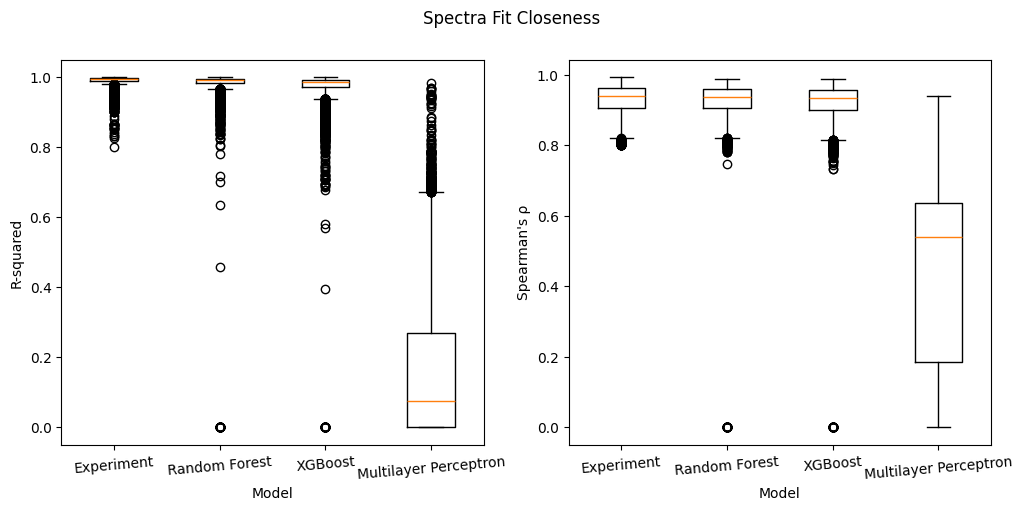

In [18]:
model_labels = ['Experiment', 'Random Forest', 'XGBoost',  'Multilayer Perceptron']
model_scores = [all_experimental_r2, rf_r2_scores, xgb_r2_scores, mlp_r2_scores]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].boxplot(model_scores)
ax[0].set_xlabel('Model')
ax[0].set_ylabel('R-squared')
ax[0].set_xticklabels(model_labels, rotation=5)

model_scores = [all_experimental_spear, rf_spear_scores, xgb_spear_scores, mlp_spear_scores]
ax[1].boxplot(model_scores)
ax[1].set_xlabel('Model')
ax[1].set_ylabel("Spearman's ρ")
ax[1].set_xticklabels(model_labels, rotation=5)

plt.suptitle('Spectra Fit Closeness')
plt.show()

In [28]:
rf_improved_ct = 0
xgb_improved_ct = 0
mlp_improved_ct = 0
for i in range(len(all_experimental_r2)):
    if rf_r2_scores[i] > all_experimental_r2[i]:
        rf_improved_ct += 1
    if mlp_r2_scores[i] > all_experimental_r2[i]:
        mlp_improved_ct += 1
    if xgb_r2_scores[i] > all_experimental_r2[i]:
        xgb_improved_ct += 1

rf_improved_percent = round(rf_improved_ct / len(all_experimental_r2) * 100, 0)
xgb_improved_percent = round(xgb_improved_ct / len(all_experimental_r2) * 100, 0)
mlp_improved_percent = round(mlp_improved_ct / len(all_experimental_r2) * 100, 0)

print(f"Random forest improved {rf_improved_percent}% of fits according to R-squared")
print(f"XGBoost improved {xgb_improved_percent}% of fits according to R-squared")
print(f"MLP improved {mlp_improved_percent}% of fits according to R-squared")

rf_improved_ct = 0
xgb_improved_ct = 0
mlp_improved_ct = 0
for i in range(len(all_experimental_spear)):
    if rf_spear_scores[i] > all_experimental_spear[i]:
        rf_improved_ct += 1
    if mlp_spear_scores[i] > all_experimental_spear[i]:
        mlp_improved_ct += 1
    if xgb_spear_scores[i] > all_experimental_spear[i]:
        xgb_improved_ct += 1

rf_improved_percent = round(rf_improved_ct / len(all_experimental_r2) * 100, 0)
xgb_improved_percent = round(xgb_improved_ct / len(all_experimental_r2) * 100, 0)
mlp_improved_percent = round(mlp_improved_ct / len(all_experimental_r2) * 100, 0)

print(f"Random forest improved {rf_improved_percent}% of fits according to Spearman's ρ")
print(f"XGBoost improved {xgb_improved_percent}% of fits according to Spearman's ρ")
print(f"MLP improved {mlp_improved_percent}% of fits according to Spearman's ρ")

Random forest improved 38.0% of fits according to R-squared
XGBoost improved 17.0% of fits according to R-squared
MLP improved 0.0% of fits according to R-squared
Random forest improved 50.0% of fits according to Spearman's ρ
XGBoost improved 37.0% of fits according to Spearman's ρ
MLP improved 0.0% of fits according to Spearman's ρ


In [19]:
mlp_best_r2 = mlp_r2_scores.index(max(mlp_r2_scores))
mlp_best_spear = mlp_spear_scores.index(max(mlp_spear_scores))
xgb_best_r2 = xgb_r2_scores.index(max(xgb_r2_scores))
xgb_best_spear = xgb_spear_scores.index(max(xgb_spear_scores))
rf_best_r2 = rf_r2_scores.index(max(rf_r2_scores))
rf_best_spear = rf_spear_scores.index(max(rf_spear_scores))

In [20]:
def get_fit_at_index(i, predictions):
    elem_names = []
    for col in elements.columns:
        if elements.iloc[i][col] != -1:
            elem_names.append(col)
            
    predicted_fit_params = dict(predictions.iloc[i])
    predicted_fit_params.update(dict(fit_params_constant.iloc[0]))
    predicted_fit_spectra, predicted_resize_spectra = get_fitted_spectra(predicted_fit_params, spectra.iloc[i], elem_names)
    return predicted_fit_spectra, predicted_resize_spectra

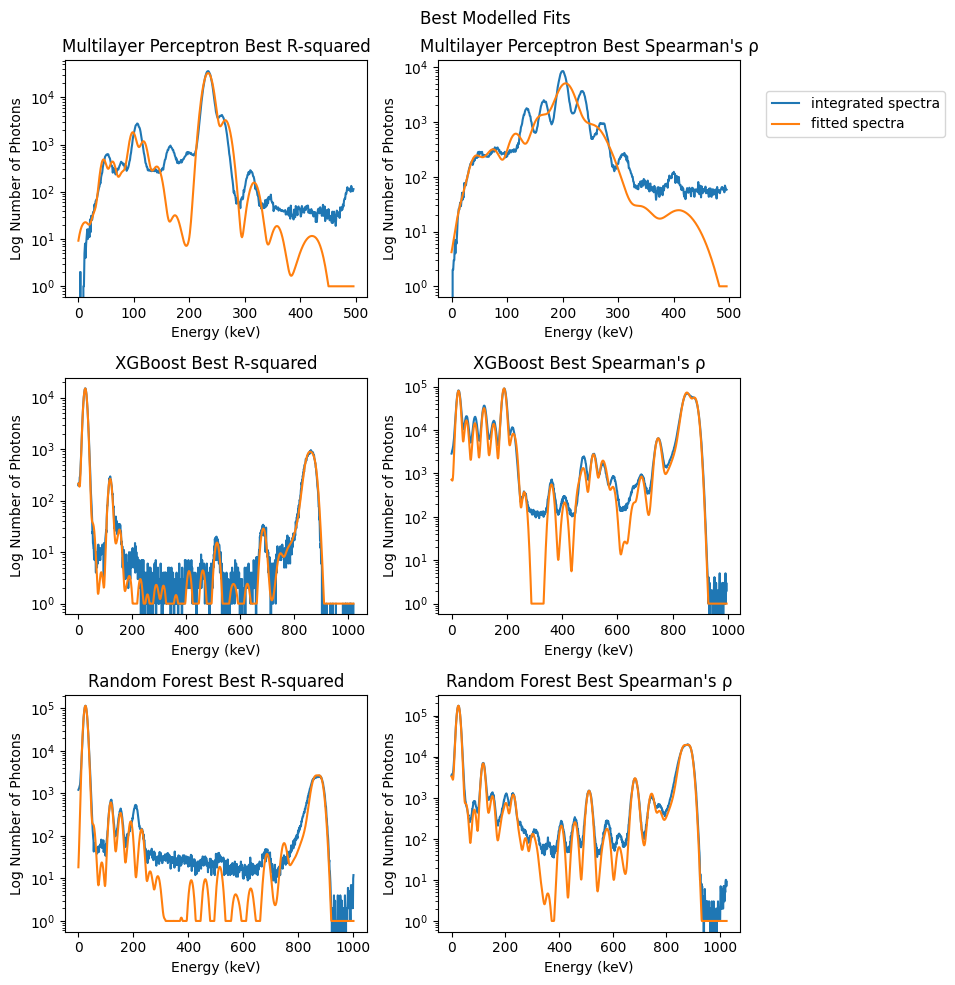

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

predicted_fit_spectra, predicted_resize_spectra = get_fit_at_index(mlp_best_r2, mlp_predicted_df)
i_ax = np.linspace(0, predicted_resize_spectra.size-1, predicted_resize_spectra.size)
f_ax = np.linspace(0, predicted_fit_spectra.size-1, predicted_fit_spectra.size)

axs[0][0].plot(i_ax, predicted_resize_spectra, label="integrated spectra")
axs[0][0].plot(f_ax, predicted_fit_spectra, label="fitted spectra")
axs[0][0].set_ylabel('Log Number of Photons')
axs[0][0].set_xlabel('Energy (keV)')
axs[0][0].set_title("Multilayer Perceptron Best R-squared")
axs[0][0].set_yscale('log')

predicted_fit_spectra, predicted_resize_spectra = get_fit_at_index(mlp_best_spear, mlp_predicted_df)
i_ax = np.linspace(0, predicted_resize_spectra.size-1, predicted_resize_spectra.size)
f_ax = np.linspace(0, predicted_fit_spectra.size-1, predicted_fit_spectra.size)

axs[0][1].plot(i_ax, predicted_resize_spectra, label="integrated spectra")
axs[0][1].plot(f_ax, predicted_fit_spectra, label="fitted spectra")
axs[0][1].set_ylabel('Log Number of Photons')
axs[0][1].set_xlabel('Energy (keV)')
axs[0][1].set_title("Multilayer Perceptron Best Spearman's ρ")
axs[0][1].set_yscale('log')

predicted_fit_spectra, predicted_resize_spectra = get_fit_at_index(xgb_best_r2, xgb_predicted_df)
i_ax = np.linspace(0, predicted_resize_spectra.size-1, predicted_resize_spectra.size)
f_ax = np.linspace(0, predicted_fit_spectra.size-1, predicted_fit_spectra.size)

axs[1][0].plot(i_ax, predicted_resize_spectra, label="integrated spectra")
axs[1][0].plot(f_ax, predicted_fit_spectra, label="fitted spectra")
axs[1][0].set_ylabel('Log Number of Photons')
axs[1][0].set_xlabel('Energy (keV)')
axs[1][0].set_title("XGBoost Best R-squared")
axs[1][0].set_yscale('log')

predicted_fit_spectra, predicted_resize_spectra = get_fit_at_index(xgb_best_spear, xgb_predicted_df)
i_ax = np.linspace(0, predicted_resize_spectra.size-1, predicted_resize_spectra.size)
f_ax = np.linspace(0, predicted_fit_spectra.size-1, predicted_fit_spectra.size)

axs[1][1].plot(i_ax, predicted_resize_spectra, label="integrated spectra")
axs[1][1].plot(f_ax, predicted_fit_spectra, label="fitted spectra")
axs[1][1].set_ylabel('Log Number of Photons')
axs[1][1].set_xlabel('Energy (keV)')
axs[1][1].set_title("XGBoost Best Spearman's ρ")
axs[1][1].set_yscale('log')

predicted_fit_spectra, predicted_resize_spectra = get_fit_at_index(rf_best_r2, rf_predicted_df)
i_ax = np.linspace(0, predicted_resize_spectra.size-1, predicted_resize_spectra.size)
f_ax = np.linspace(0, predicted_fit_spectra.size-1, predicted_fit_spectra.size)

axs[2][0].plot(i_ax, predicted_resize_spectra, label="integrated spectra")
axs[2][0].plot(f_ax, predicted_fit_spectra, label="fitted spectra")
axs[2][0].set_ylabel('Log Number of Photons')
axs[2][0].set_xlabel('Energy (keV)')
axs[2][0].set_title("Random Forest Best R-squared")
axs[2][0].set_yscale('log')

predicted_fit_spectra, predicted_resize_spectra = get_fit_at_index(rf_best_spear, rf_predicted_df)
i_ax = np.linspace(0, predicted_resize_spectra.size-1, predicted_resize_spectra.size)
f_ax = np.linspace(0, predicted_fit_spectra.size-1, predicted_fit_spectra.size)

axs[2][1].plot(i_ax, predicted_resize_spectra, label="integrated spectra")
axs[2][1].plot(f_ax, predicted_fit_spectra, label="fitted spectra")
axs[2][1].set_ylabel('Log Number of Photons')
axs[2][1].set_xlabel('Energy (keV)')
axs[2][1].set_title("Random Forest Best Spearman's ρ")
axs[2][1].set_yscale('log')

axs[0][1].legend(loc='upper right', bbox_to_anchor=(1.7, 0.9))

plt.suptitle("Best Modelled Fits")
plt.tight_layout()
plt.savefig("BestModelledFits.png")
plt.show()